# Library

In [2]:
pip install matplotlib


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opendatasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 21.9 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.5.13-py3-none-any.whl size=77717 sha256=6189bd04f051548eaf86de7858b7ce7c4ec477968fdab69b48d37ebf5565b788
  Stored in directory: /root/.cache/pip/wheels/e6/8e/67/e07554a720a493dc6b39b30488590ba92ed45448ad0134d253
Successfully built kaggle

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
# Others
import shutil
import random

# Load dataset

In [5]:
# Download dataset
od.download('https://www.kaggle.com/datasets/ahmadhabibhasanzein/apple-data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  ahmadhabibhasanzein


Your Kaggle Key:

  ········


100%|██████████| 216M/216M [00:15<00:00, 14.4MB/s] 


In [5]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "apple-data/Apple/train",
    label_mode="categorical",
    class_names=['Apple Black rot', 'Apple Scab Leaf', 'Apple leaf Healthy', 'Apple rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "apple-data/Apple/valid",
    label_mode="categorical",
    class_names=['Apple Black rot', 'Apple Scab Leaf', 'Apple leaf Healthy', 'Apple rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 8014 files belonging to 4 classes.
==========================Validation Data====================
Found 1943 files belonging to 4 classes.


In [6]:
# All images will be rescaled by 1./256. and Augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("apple-data/Apple/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("apple-data/Apple/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 8014 images belonging to 4 classes.
Found 1943 images belonging to 4 classes.


# List Resource

In [7]:
# Check GPU
!nvidia-smi

Thu May 25 04:57:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.05    Driver Version: 525.85.05    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    On   | 00000000:67:00.0 Off |                  Off |
| 41%   41C    P8    15W / 140W |      6MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling With Augmentation

## Xception Model 1

In [10]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Apple_Xception_model1_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [11]:
# Define Model
Xception1_model = tf.keras.models.Sequential([
    # Xception Layer
    Xception(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
Xception1_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
Xception1_model.summary()

83683744/83683744 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21,387,052
Trainable params: 21,332,524
Non

In [12]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_Xception_model_1 = Xception1_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
401/401 [==============================] - ETA: 0s - loss: 0.2611 - accuracy: 0.9214
Epoch 1: val_accuracy improved from -inf to 0.98456, saving model to Apple_Xception_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Augmented/assets


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Augmented/assets


401/401 [==============================] - 115s 223ms/step - loss: 0.2611 - accuracy: 0.9214 - val_loss: 0.0555 - val_accuracy: 0.9846 - lr: 0.0010
Epoch 2/100
401/401 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9624
Epoch 2: val_accuracy did not improve from 0.98456
401/401 [==============================] - 72s 180ms/step - loss: 0.1282 - accuracy: 0.9624 - val_loss: 0.2479 - val_accuracy: 0.9655 - lr: 0.0010
Epoch 3/100
401/401 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.9743
Epoch 3: val_accuracy did not improve from 0.98456
401/401 [==============================] - 73s 182ms/step - loss: 0.0948 - accuracy: 0.9743 - val_loss: 0.0672 - val_accuracy: 0.9830 - lr: 0.0010
Epoch 4/100
401/401 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.9742
Epoch 4: val_accuracy improved from 0.98456 to 0.99022, saving model to Apple_Xception_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Augmented/assets


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Augmented/assets


401/401 [==============================] - 86s 215ms/step - loss: 0.0890 - accuracy: 0.9742 - val_loss: 0.0237 - val_accuracy: 0.9902 - lr: 0.0010
Epoch 5/100
401/401 [==============================] - ETA: 0s - loss: 0.0701 - accuracy: 0.9802
Epoch 5: val_accuracy improved from 0.99022 to 0.99228, saving model to Apple_Xception_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Augmented/assets


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Augmented/assets


401/401 [==============================] - 86s 214ms/step - loss: 0.0701 - accuracy: 0.9802 - val_loss: 0.0200 - val_accuracy: 0.9923 - lr: 0.0010
Epoch 6/100
401/401 [==============================] - ETA: 0s - loss: 0.0504 - accuracy: 0.9834
Epoch 6: val_accuracy did not improve from 0.99228
401/401 [==============================] - 71s 177ms/step - loss: 0.0504 - accuracy: 0.9834 - val_loss: 0.2586 - val_accuracy: 0.9496 - lr: 0.0010
Epoch 7/100
401/401 [==============================] - ETA: 0s - loss: 0.0614 - accuracy: 0.9819
Epoch 7: val_accuracy did not improve from 0.99228
401/401 [==============================] - 72s 180ms/step - loss: 0.0614 - accuracy: 0.9819 - val_loss: 0.0420 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 8/100
401/401 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.9779
Epoch 8: val_accuracy did not improve from 0.99228
401/401 [==============================] - 72s 179ms/step - loss: 0.0737 - accuracy: 0.9779 - val_loss: 0.2020 - va

INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Augmented/assets


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Augmented/assets


401/401 [==============================] - 87s 216ms/step - loss: 0.0715 - accuracy: 0.9795 - val_loss: 0.0188 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 10/100
401/401 [==============================] - ETA: 0s - loss: 0.0403 - accuracy: 0.9875
Epoch 10: val_accuracy improved from 0.99331 to 0.99382, saving model to Apple_Xception_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Augmented/assets


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Augmented/assets


401/401 [==============================] - 86s 216ms/step - loss: 0.0403 - accuracy: 0.9875 - val_loss: 0.0160 - val_accuracy: 0.9938 - lr: 0.0010
Epoch 11/100
401/401 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 0.9833
Epoch 11: val_accuracy did not improve from 0.99382
401/401 [==============================] - 72s 178ms/step - loss: 0.0518 - accuracy: 0.9833 - val_loss: 0.0473 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 12/100
401/401 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9880
Epoch 12: val_accuracy improved from 0.99382 to 0.99537, saving model to Apple_Xception_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Augmented/assets


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Augmented/assets


401/401 [==============================] - 86s 213ms/step - loss: 0.0358 - accuracy: 0.9880 - val_loss: 0.0163 - val_accuracy: 0.9954 - lr: 0.0010
Epoch 13/100
401/401 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 0.9842
Epoch 13: val_accuracy did not improve from 0.99537
401/401 [==============================] - 71s 178ms/step - loss: 0.0497 - accuracy: 0.9842 - val_loss: 0.1365 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 14/100
401/401 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9807
Epoch 14: val_accuracy did not improve from 0.99537
401/401 [==============================] - 71s 178ms/step - loss: 0.0664 - accuracy: 0.9807 - val_loss: 0.0488 - val_accuracy: 0.9866 - lr: 0.0010
Epoch 15/100
401/401 [==============================] - ETA: 0s - loss: 0.0316 - accuracy: 0.9895
Epoch 15: val_accuracy did not improve from 0.99537

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
401/401 [=====================

INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Augmented/assets


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Augmented/assets


401/401 [==============================] - 86s 214ms/step - loss: 0.0198 - accuracy: 0.9926 - val_loss: 8.5933e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 17/100
401/401 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9945
Epoch 17: val_accuracy did not improve from 1.00000
401/401 [==============================] - 72s 179ms/step - loss: 0.0137 - accuracy: 0.9945 - val_loss: 0.0035 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 18/100
401/401 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9954
Epoch 18: val_accuracy did not improve from 1.00000
401/401 [==============================] - 72s 178ms/step - loss: 0.0150 - accuracy: 0.9954 - val_loss: 2.4500e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 19/100
401/401 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9964
Epoch 19: val_accuracy did not improve from 1.00000
401/401 [==============================] - 71s 178ms/step - loss: 0.0105 - accuracy: 0.99

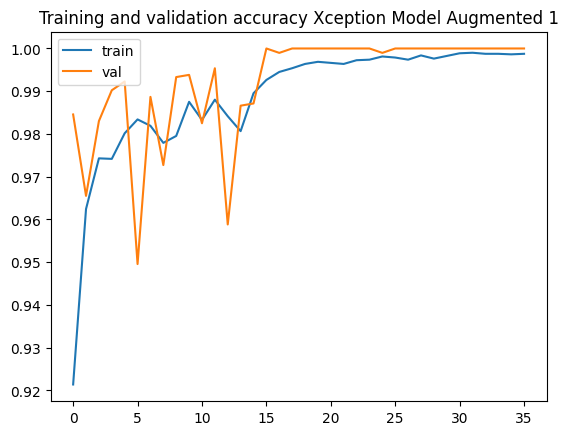

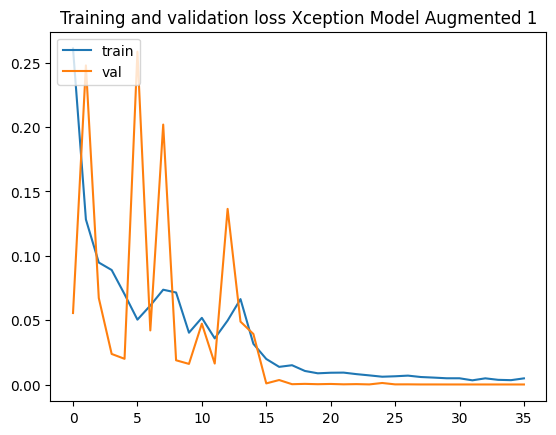

In [13]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_Xception_model_1.history['accuracy' ]
val_acc  = history_Xception_model_1.history['val_accuracy' ]
loss     = history_Xception_model_1.history['loss' ]
val_loss = history_Xception_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy Xception Model Augmented 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss Xception Model Augmented 1')
plt.legend(['train', 'val'], loc='upper left')

## Xception Model 2

In [17]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Apple_Xception_model2_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [18]:
# Define Model
Xception_model_2 = tf.keras.models.Sequential([
    # Xception Layer
    Xception(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
Xception_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
Xception_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21,387,052
Trainable params: 21,332,524
Non-trainable params: 54,528
_____________________________________

In [19]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_Xception_model_2 = Xception_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
401/401 [==============================] - ETA: 0s - loss: 0.2350 - accuracy: 0.9300
Epoch 1: val_accuracy improved from -inf to 0.96089, saving model to Apple_Xception_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_Xception_model2_Based_Augmented/assets


INFO:tensorflow:Assets written to: Apple_Xception_model2_Based_Augmented/assets


401/401 [==============================] - 107s 219ms/step - loss: 0.2350 - accuracy: 0.9300 - val_loss: 0.6577 - val_accuracy: 0.9609 - lr: 0.0010
Epoch 2/100
401/401 [==============================] - ETA: 0s - loss: 0.1079 - accuracy: 0.9688
Epoch 2: val_accuracy improved from 0.96089 to 0.99794, saving model to Apple_Xception_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_Xception_model2_Based_Augmented/assets


INFO:tensorflow:Assets written to: Apple_Xception_model2_Based_Augmented/assets


401/401 [==============================] - 86s 214ms/step - loss: 0.1079 - accuracy: 0.9688 - val_loss: 0.0090 - val_accuracy: 0.9979 - lr: 0.0010
Epoch 3/100
401/401 [==============================] - ETA: 0s - loss: 0.1044 - accuracy: 0.9696
Epoch 3: val_accuracy did not improve from 0.99794
401/401 [==============================] - 72s 180ms/step - loss: 0.1044 - accuracy: 0.9696 - val_loss: 0.0252 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 4/100
401/401 [==============================] - ETA: 0s - loss: 0.0855 - accuracy: 0.9735
Epoch 4: val_accuracy did not improve from 0.99794
401/401 [==============================] - 72s 179ms/step - loss: 0.0855 - accuracy: 0.9735 - val_loss: 0.1242 - val_accuracy: 0.9748 - lr: 0.0010
Epoch 5/100
401/401 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.9847
Epoch 5: val_accuracy did not improve from 0.99794
401/401 [==============================] - 72s 179ms/step - loss: 0.0445 - accuracy: 0.9847 - val_loss: 0.0325 - va

INFO:tensorflow:Assets written to: Apple_Xception_model2_Based_Augmented/assets


INFO:tensorflow:Assets written to: Apple_Xception_model2_Based_Augmented/assets


401/401 [==============================] - 86s 215ms/step - loss: 0.0322 - accuracy: 0.9880 - val_loss: 0.0016 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 10/100
401/401 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9814
Epoch 10: val_accuracy did not improve from 1.00000
401/401 [==============================] - 73s 181ms/step - loss: 0.0629 - accuracy: 0.9814 - val_loss: 0.0687 - val_accuracy: 0.9820 - lr: 0.0010
Epoch 11/100
401/401 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9857
Epoch 11: val_accuracy did not improve from 1.00000
401/401 [==============================] - 72s 180ms/step - loss: 0.0388 - accuracy: 0.9857 - val_loss: 0.0040 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 12/100
401/401 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9881
Epoch 12: val_accuracy did not improve from 1.00000
401/401 [==============================] - 73s 181ms/step - loss: 0.0342 - accuracy: 0.9881 - val_loss: 0.004

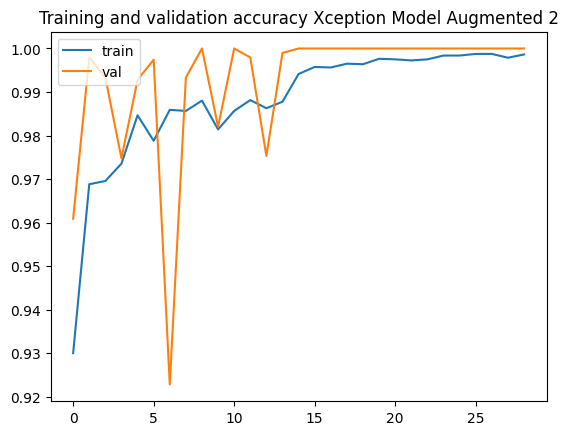

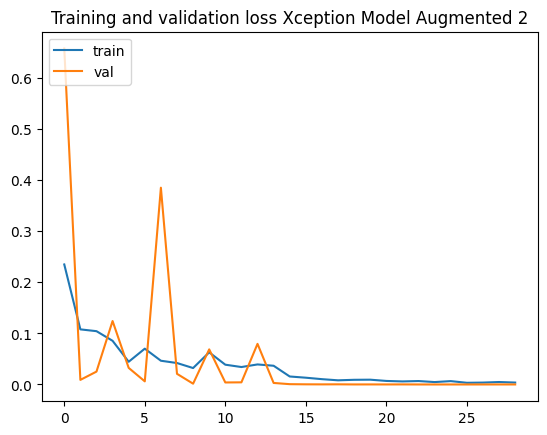

In [20]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_Xception_model_2.history['accuracy' ]
val_acc  = history_Xception_model_2.history['val_accuracy' ]
loss     = history_Xception_model_2.history['loss' ]
val_loss = history_Xception_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy Xception Model Augmented 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss Xception Model Augmented 2')
plt.legend(['train', 'val'], loc='upper left')

# Download Model

In [ ]:
!zip -r /content/Apple_Xception_model1_Based_Augmented.zip /content/Apple_Xception_model1_Based_Augmented

In [ ]:
!zip -r /content/Apple_Xception_model2_Based_Augmented.zip /content/Apple_Xception_model2_Based_Augmented

In [ ]:
from google.colab import files

# Specify the file path
file_path_1 = '/content/Apple_Xception_model1_Based_Augmented'  
file_path_2 = '/content/Apple_Xception_model2_Based_Augmented'  

# Download the file
files.download(file_path_1)
files.download(file_path_2)